# Core

In this notebook, we will go through the core functionality of the GPAX library.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import arviz as az

from gpax.core import (
    Parameter,
    Module,
    get_default_jitter,
    set_default_jitter,
    get_default_prior,
    set_default_prior,
    get_positive_bijector,
    set_positive_bijector,
)

/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: LOCAL is an invalid version and will not be supported in a future release
  warnings.warn(


## Parameter

Parameter object contains mainly three components:
1. Value of the parameter which is a `jax` array.
2. Bijector for the parameter. This is a `tfb` object. It is used to constrain the parameter in a certain range.
3. Prior distribution of the parameter. This is a `tfd` object. It is used to either sample from the prior or compute the log probability of the parameter.

### Creating a parameter

By default, the bijector is `tfb.Identity()` and the prior is `None`.

In [2]:
param = Parameter(value=[0.0, 1.0])
print(f"{param = }")
print(f"{param.bijector = }")
print(f"{param.prior = }")

param = Parameter(shape=(2,))
param.bijector = <tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>
param.prior = None


If, prior is set and bijector is not set, then the bijector will be infered automatically using `_default_event_space_bijector()` method of `tfd` objects. For example, `tfb.Softplus` is the default bijector for `tfd.Exponential` prior.

In [3]:
param = Parameter(value=[0.5, 1.0], prior=tfd.Exponential(rate=1.0))
print(f"{param = }")
print(f"{param.bijector = }")
print(f"{param.prior = }")

param = Parameter(shape=(2,))
param.bijector = <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>
param.prior = <tfp.distributions.Exponential 'Exponential' batch_shape=[] event_shape=[] dtype=float32>


If bijector is set and prior is not set, prior will be set to `None`, i.e. no prior. This is useful when you want to constrain the parameter but do not want to use a prior.  

In [4]:
param = Parameter(value=[0.5, 1.0], bijector=tfb.Exp())
print(f"{param = }")
print(f"{param.bijector = }")
print(f"{param.prior = }")

param = Parameter(shape=(2,))
param.bijector = <tfp.bijectors.Exp 'exp' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>
param.prior = None


Note that, value is always stored in unconstrained space. Which means that, if we pass a value to the parameter, it will be inverse transformed by the bijector before being stored.

In [5]:
param = Parameter(value=[0.5, 1.5], bijector=tfb.Exp())
print(param._raw_value)

[-0.6931472   0.40546513]


`_raw_value` is not a recommended way to access the value of a parameter. We will see how to access the value of a parameter in the next section.

### Get values

In [6]:
param = Parameter(value=jnp.ones((2,)) * 2.0, bijector=tfb.Exp(), prior=None)

We can access the value of a parameter in two ways. When the value is accessed in this way, underlying `_raw_value` is constrained by the bijector on the fly and returned. 

In [7]:
print(param())
print(param.get_value())
print(type(param()))

[2. 2.]
[2. 2.]
<class 'jaxlib.xla_extension.DeviceArray'>


We can get the raw values in this way:

In [8]:
print(param.get_raw_value())

[0.6931472 0.6931472]


### Set values

We can set values to a parameters in two ways. The following way is used if we want to set the values which are in constrained space.

In [9]:
param.set_value([2.0, 2.0])
print(param(), param().dtype)

[2. 2.] float32


To set the values which are in the unconstrained space, we can use the following way:

In [10]:
param.set_raw_value([0.6, 0.6])
print(param(), param().dtype)

[1.8221189 1.8221189] float32


### Random initialization

When we call the `initialize` method, the parameter is initialized randomly from the prior distribution.

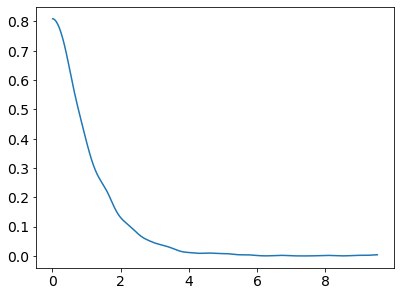

In [11]:
param = Parameter(value=jnp.ones(1000), bijector=tfb.Exp(), prior=tfd.Exponential(rate=1.0))

key = jax.random.PRNGKey(0)
param.initialize(key)

az.plot_dist(param());

If the prior is `None`, `raw_value` of the parameter is initialized using `DEFAULT_PRIOR` distribution which is $\mathcal{N}(0, 1)$.

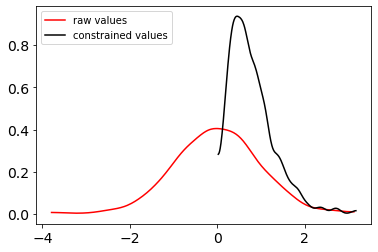

In [12]:
param = Parameter(value=jnp.ones(1000), bijector=tfb.Softplus())

key = jax.random.PRNGKey(0)
param.initialize(key)

az.plot_dist(param.get_raw_value(), color="r", label="raw values")
az.plot_dist(param(), color="k", label="constrained values");

### Get log probability

We can also compute log probability of a parameter using the `log_prob` method.

In [13]:
param = Parameter(value=jnp.ones(1000), bijector=tfb.Softplus(), prior=tfd.Exponential(rate=1.0))

key = jax.random.PRNGKey(0)
param.initialize(key)
log_probs = param.log_prob()
print(log_probs.shape)
print(log_probs.sum())

(1000,)
-992.31934


### Enable/Disable trainability

We can use the `trainable` method to enable or disable the training of a parameter. Note that, `trainable` method returns the parameter itself. So, we can use it in a chain.

In [14]:
def fun_trainable(x):
    param = Parameter(value=x, bijector=tfb.Softplus())
    return (param() ** 2).sum()


def fun_non_trainable(x):
    param = Parameter(value=x, bijector=tfb.Softplus()).trainable(False)
    return (param() ** 2).sum()


print(jax.grad(fun_trainable)(jnp.array([1.0, 2.0, 4.0])))
print(jax.grad(fun_non_trainable)(jnp.array([1.0, 2.0, 3.0])))

[2. 4. 8.]
[0. 0. 0.]


We can see the gradient of the parameter is zero when it is not trainable.

## Module

`Module` is a core class from which all other modules of GPAX are derived. It shares a few common functionalities with `torch.nn.Module` but has additional features as needed for GPAX. There are two core properties of a module:
1. Parameters: A list of parameters of the module stored in `self._parameters` dictionary.
2. Submodules: A list of submodules of the module stored in `self._modules` dictionary.

We will create an example module to understand the core functionalities of a module.

In [15]:
class Child_A(Module):
    def __init__(self, value):
        super().__init__()
        self.param_a = Parameter(value=value, bijector=tfb.Exp(), prior=tfd.HalfNormal(scale=1.0))


class Child_B(Module):
    def __init__(self, value):
        super().__init__()
        self.param_b = Parameter(value=value, bijector=tfb.Exp())


class Parent(Module):
    def __init__(self, value_a, value_b):
        super().__init__()
        self.child_a = Child_A(value=value_a)
        self.child_b = Child_B(value=value_b)

Few things to note here:
1. Any `Parameter` object assigned to `self` is automatically added to the `self._parameters` dictionary.
2. Any `Module` object object assigned to `self` is automatically added to the `self._modules` dictionary.

(module-get-params)=
### Get parameters

We can recursively get the parameters of a module and its submodules using either `get_parameters` or `get_raw_parameters` method. The difference between these two methods is that, `get_parameters` returns the constrained values of the parameters while `get_raw_parameters` returns the unconstrained values of the parameters.

In [16]:
module = Parent(value_a=[1.0, 2.0], value_b=[3.0, 4.0])
print(module.get_parameters())
print(module.get_raw_parameters())

{'child_a': {'param_a': DeviceArray([1., 2.], dtype=float32)}, 'child_b': {'param_b': DeviceArray([3., 4.], dtype=float32)}}
{'child_a': {'param_a': DeviceArray([0.       , 0.6931472], dtype=float32)}, 'child_b': {'param_b': DeviceArray([1.0986123, 1.3862944], dtype=float32)}}


In case, you'd like to return the parameters as objects and not as a dictionary, you can do this:

In [17]:
print(module.get_parameters(raw_dict=False))

{'child_a': {'param_a': Parameter(shape=(2,))}, 'child_b': {'param_b': Parameter(shape=(2,))}}


### Set parameters

We can modify the parameter dictionary returned by the methods shown in [Get parameters](module-get-params) and set them back to the module using either `set_parameters` or `set_raw_parameters` method. The difference between these two methods is that, `set_parameters` sets the constrained values of the parameters while `set_raw_parameters` sets the unconstrained values of the parameters.

In [18]:
module = Parent(value_a=[1.0, 2.0], value_b=[3.0, 4.0])
raw_values = module.get_raw_parameters()
print(raw_values)

{'child_a': {'param_a': DeviceArray([0.       , 0.6931472], dtype=float32)}, 'child_b': {'param_b': DeviceArray([1.0986123, 1.3862944], dtype=float32)}}


In [19]:
raw_values["child_a"]["param_a"] = jnp.array([0.5, 0.5])
module.set_raw_parameters(raw_values)
print(module.get_raw_parameters())

{'child_a': {'param_a': DeviceArray([0.5, 0.5], dtype=float32)}, 'child_b': {'param_b': DeviceArray([1.0986123, 1.3862944], dtype=float32)}}


### Random initialization

When we call the `initialize` method, all the parameters of the module and its submodules are initialized randomly from their prior distributions.

In [20]:
module = Parent(value_a=[1.0, 2.0], value_b=[3.0, 4.0])
print(module.get_parameters())

key = jax.random.PRNGKey(0)
module.initialize(key)

print(module.get_parameters())

{'child_a': {'param_a': DeviceArray([1., 2.], dtype=float32)}, 'child_b': {'param_b': DeviceArray([3., 4.], dtype=float32)}}
{'child_a': {'param_a': DeviceArray([0.00870701, 0.04888523], dtype=float32)}, 'child_b': {'param_b': DeviceArray([1.1799661, 0.8048073], dtype=float32)}}


### Get log probability

We can compute log probability of all the parameters of the module and its submodules using the `log_prob` method.

In [21]:
module = Parent(value_a=[1.0, 2.0], value_b=[3.0, 4.0])
print(module.log_prob())
print(module.log_prob(reduce=False))  # log_prob for each parameter

-2.951583
{'child_a': {'param_a': DeviceArray([-0.72579134, -2.2257915 ], dtype=float32)}, 'child_b': {'param_b': DeviceArray([0., 0.], dtype=float32)}}


### Enable/Disable trainability

We can use the `trainable` method to enable or disable the training of all the parameters of the module and its submodules. Note that, `trainable` method returns the module itself. So, we can use it in a chain.

In [22]:
module = Parent(value_a=[1.0, 2.0], value_b=[3.0, 4.0])
module = module.trainable(False)

module

## Get or set defaults

There are several default values which are used in GPAX. For example, `DEFAULT_PRIOR` is the default prior distribution used for initializing the parameters. We can get or set these default values using the following methods:

### Default prior

In [23]:
default_prior = get_default_prior()
print(default_prior)
set_default_prior(tfd.Exponential(rate=1.0))
default_prior = get_default_prior()
print(default_prior)

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)
tfp.distributions.Exponential("Exponential", batch_shape=[], event_shape=[], dtype=float32)


### Default positive bijection

In [24]:
default_positive_bijector = get_positive_bijector()
print(default_positive_bijector)
set_positive_bijector(tfb.Exp())
default_positive_bijector = get_positive_bijector()
print(default_positive_bijector)

tfp.bijectors.Softplus("softplus", batch_shape=[], min_event_ndims=0)
tfp.bijectors.Exp("exp", batch_shape=[], min_event_ndims=0)


### Default jitter

In [25]:
default_jitter = get_default_jitter()
print(default_jitter)
set_default_jitter(1e-3)
default_jitter = get_default_jitter()
print(default_jitter)

1e-06
0.001


## Advanced

### Parameter as a PyTree

`Parameter` objects are also PyTrees and we can pass them directly to the loss function. This reduces the complexity of the loss function and makes it more readable.

In [26]:
def fun_trainable(param):
    return (param() ** 2).sum()


def fun_non_trainable(param):
    param.trainable(False)
    return (param() ** 2).sum()


value = jnp.array([1.0, 2.0, 4.0])
param = Parameter(value=value, bijector=tfb.Softplus())

print(jax.grad(lambda x: (jax.nn.softplus(x) ** 2).sum())(value))
print(jtu.tree_leaves(jax.grad(fun_trainable)(param)))
print(jtu.tree_leaves(jax.grad(fun_non_trainable)(param)))

[1.9201423 3.7467837 7.891758 ]
[DeviceArray([1.2642411, 3.4586592, 7.853476 ], dtype=float32)]
[DeviceArray([0., 0., 0.], dtype=float32)]
